# Is seasonality a good predictor of implied volatility?

First, we need to define seasonality. We're going to create a "seasonality" parameter using a sine wave, mapping it's peak to June 30th and it's trough to January 1st.

In [32]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import timeit

from scipy.optimize import curve_fit

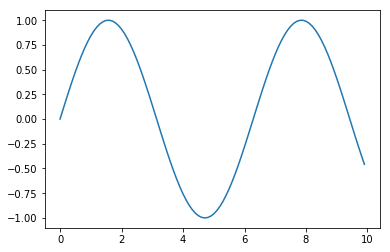

In [31]:
#plot basic sine wave
x = np.arange(0,10,.1)
y = np.sin(x)
plt.plot(x,y)
plt.show()

In [3]:
# double check function for max/min amplitude
print(np.sin(np.pi/2))
print(np.sin(-np.pi/2))

1.0
-1.0


In [4]:
# define seasonality function we will be using
# currently uses sine function, could convert to seasonality = -np.cos(x)
# where x is number of days from beg of year * 2pi / number of days in year

def date_season(date):
    year = date.year
    min_season = pd.datetime(year,1,1)
    max_season = pd.datetime(year,7,2)
    dif = abs(max_season - date)
    dif_days = dif.days
    x = (((max_season - min_season).days) - dif.days * 2) / (max_season - min_season).days
    seasonality = np.sin(x * (np.pi) / 2)
    return(seasonality)

Now we need to map to calendar

In [5]:
# create pandas dataframe with a range of dates
start = dt.date(2017,1,1)
end = dt.date(2019,12,31)
df = pd.DataFrame({'Date': pd.date_range(start, end, freq="D")})

# map seasonality parameter to the range of dates
# works because there is only one column in the df we previously created, 
# will throw an error if run twice
df['Seasonality'] = df.applymap(lambda x: date_season(x))

# check to see if seasonality parameter was mapped properly
df.head()

,Date,Seasonality
0,2017-01-01,-1.000000
1,2017-01-02,-0.999851
2,2017-01-03,-0.999404
3,2017-01-04,-0.998659
4,2017-01-05,-0.997617


### In the section below, we aggregate implied volatility data into a data frame.

In [8]:
# create custom function to wrap up data cleaning work on vol csv files
# its primary purpose is to take a CSV file and convert it to only the front month vols
# doesnt need to be generalized

def front_vol_pull(csv, min_dte, max_dte, obs_id='Observation Date', new_col='Seasonality',
                   vol_id='result', title_id='Stat', exp_id='exp_date0', 
                   location='C:/Users/Trader/Desktop/Dropbox/Data Science/DataSets/ImpVol/'):
    
    # read in csv file from location and csv input
    df = pd.read_csv(location+csv, index_col=False)
    
    #converts 'Observation Date' column from string to pandas datetime object
    df[obs_id] = pd.to_datetime(df[obs_id])
    
    # creates new dataframes, one with vol data and one with expiry dates
    dfvols = df.loc[df[title_id] == vol_id]
    dfexp = df.loc[df[title_id] == exp_id]
    
    # rename dat column in vol dataframe to 'Vol'
    dfvols.rename(columns={'Value':'Vol'}, inplace=True)
    
    # create truncated version of SFexp containing just the observation date and the expiry
    # promote the 'Observation Date' & 'Year' column to the multi-index of the dataframe
    # need to use multi-index to join with other dataframes
    dfexp_trunc = dfexp[[obs_id, 'Year', 'Value']]
    dfexp_trunc = dfexp_trunc.set_index([obs_id, 'Year'])
    
    # join the two dataframes on the multi-index of 'Observation Date' & 'Year'
    dfvols_exp = dfvols.join(dfexp_trunc, on=[obs_id, 'Year'])
    
    # remove 'Stat' column and rename 'Value' to 'Expiry', could be moved up a few lines
    del dfvols_exp[title_id]
    dfvols_exp.rename(columns={'Value':'Expiry'}, inplace=True)
    
    # converts 'Expiry' data to a pandas datetime object
    dfvols_exp['Expiry'] = pd.to_datetime(dfvols_exp['Expiry'])
    
    # creates new column with Days to Expiration as a timedelta
    dfvols_exp['DTE'] = dfvols_exp['Expiry'] - dfvols_exp[obs_id]
    
    # converts dte inputs to timedelta objects and creates new dataframe with filtered dates
    max_dte = pd.Timedelta(days=max_dte)
    min_dte = pd.Timedelta(days=min_dte)
    df_fronts = dfvols_exp[(dfvols_exp['DTE'] <= max_dte) & (dfvols_exp['DTE'] > min_dte)]
    
    #df_fronts.set_index(obs_id, inplace=True)
    #print(df_fronts.head())
    return df_fronts

From here, we want to use the custom front_vol_pull function on a list of csv files containing implied volatility data.

In [10]:
# create list of vol files

vol_files = ['SFvol.csv','SHvol.csv','SKvol.csv','SNvol.csv','SQvol.csv','SUvol.csv','SXvol.csv']

In [11]:
# create one large df with all data

full_data_set = pd.DataFrame()

tic = timeit.default_timer()

for i in vol_files:
    df = front_vol_pull(i,5,60)
    full_data_set = full_data_set.append(df)
    
toc = timeit.default_timer()
print(toc-tic)


C:\Users\Trader\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


40.42385954500003


In [12]:
# sort full_data_set based on DTE, drop entries with observation date overlap, keep shortest DTE
# resort by 'Observation Date' for better clarity, redefine as final_data

full_data_set = full_data_set.sort_values('DTE').drop_duplicates('Observation Date', keep='first')
full_data_set = full_data_set.sort_values('Observation Date')

final_data = full_data_set

In [ ]:
# convert values in 'Vol' column from string to float
# map seasonality value to observation date

final_data['Vol'] =  final_data['Vol'].astype(float)
final_data['Seasonality'] = final_data.apply(lambda x: date_season(x['Observation Date']), axis=1 )

In [22]:
print(len(final_data))
final_data.head()

2372


,Observation Date,Year,Vol,Expiry,DTE,Seasonality
15,2009-01-02,2009,41.439999,2009-02-20,49 days,-0.999851
32,2009-01-05,2009,41.939999,2009-02-20,46 days,-0.997617
49,2009-01-06,2009,43.059999,2009-02-20,45 days,-0.996278
66,2009-01-07,2009,42.179999,2009-02-20,44 days,-0.994642
83,2009-01-08,2009,40.659999,2009-02-20,43 days,-0.992709


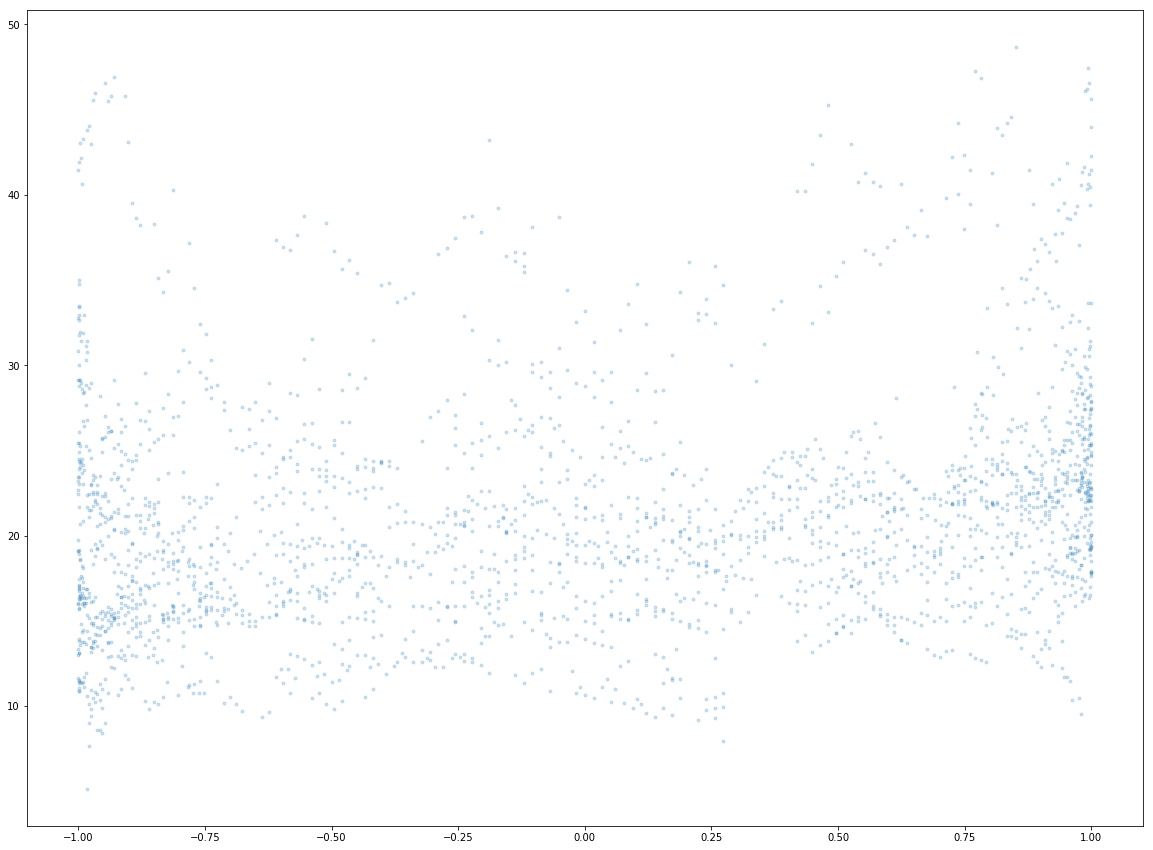

In [28]:
plt.figure(figsize=(20,15))
plt.scatter(final_data['Seasonality'], final_data['Vol'], marker='.', alpha=0.2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000052A0358>]],
      dtype=object)

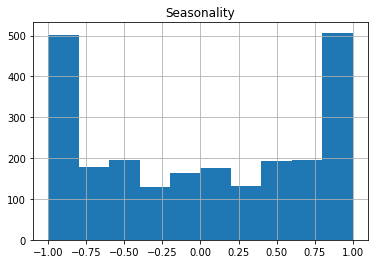

In [24]:
final_data.hist(column='Seasonality', bins=10)

Below, we attempt to fit a curve to our vol/seasonality data with a sigmoid function

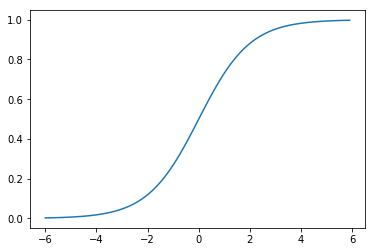

In [27]:
# create an array of numbers -6.0 to +6.0 and plot the sigmoid function using that array as input

x = np.arange(-6.0,6.0,0.1)
y = 1 / (1 + np.exp(-x))
plt.plot(x,y)

In [33]:
# define the sigmoid function that will be used in scipy.curve_fit
# this can be substituted with scipy.special.expit(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [81]:
# define our function to fit the sigmoid curve to our vol data with a k variable, min vol, and range

def sig_fit(x, k, breadth, minimum):
    return (1 / (1 + np.exp(-x*k)) * breadth) + minimum

In [97]:
print(sig_fit(0,0.5,20,10))
print(sig_fit(0,0.21,40.37,1.0))

20.0
21.185


In [146]:
xdata = final_data['Seasonality']
ydata = final_data['Vol']

#forced parameters to display nice sigmoid curve, straight line without
popt, pcov = curve_fit(sig_fit, xdata, ydata, bounds=([4,10,5],[4.1,25,25]))

print(popt)
print(pcov)

[ 4.         10.         16.15777308]
[[ 0.62646509 -0.47086065  0.23573162]
 [-0.47086065  0.48961472 -0.24566065]
 [ 0.23573162 -0.24566065  0.14501442]]


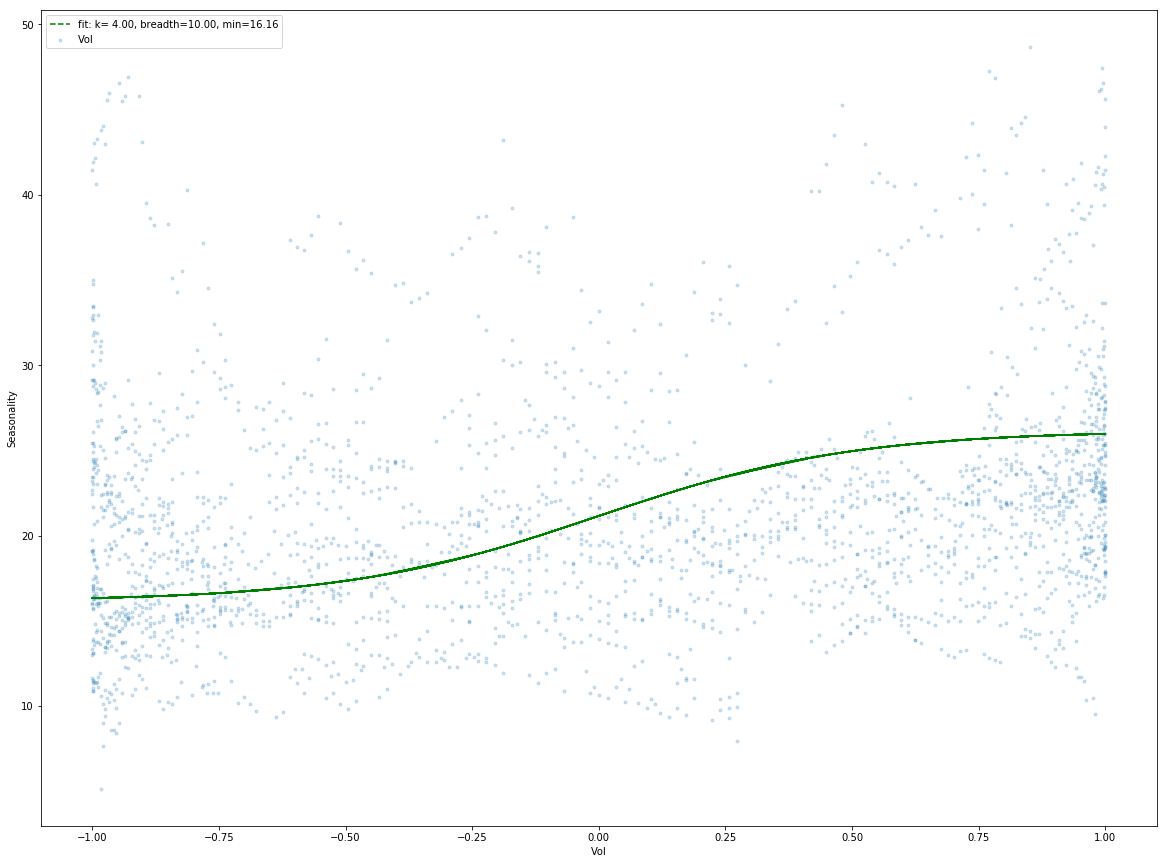

In [147]:
plt.figure(figsize=(20,15))
plt.scatter(final_data['Seasonality'], final_data['Vol'], marker='.', alpha=0.2)
plt.plot(xdata, sig_fit(xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.xlabel('Vol')
plt.ylabel('Seasonality')
plt.legend()
plt.show()

C:\Users\Trader\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


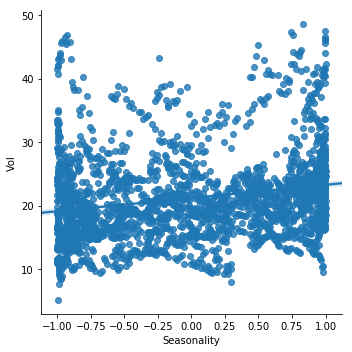

In [39]:
import seaborn as sns
sns.lmplot(x='Seasonality', y='Vol', data=final_data ,fit_reg=True)